# Cyclotron Analysis Package

## Beams

To define a beam, use the `BeamParameter` class with the ion mass in amu, the charge of the ion, and the ion energy. Do not worry about changing the mass based on the charge state, the code will do that automatically. Here we will create an Ar-11 beam:

In [1]:
from ops.cyclotron.analysis.model import BeamParameters

beam = BeamParameters(mass=39.95635, charge=11, energy=400)

The `ops.cyclotron.analysis.physics` module has a number of functions for calculating physics parameters for both fields and beams, as well as commonly used constants. Here we can verify that the ion mass has been adjusted by the charge state.

In [2]:
from ops.cyclotron.analysis.physics import calculate_ion_mass_in_amu
ion_mass = calculate_ion_mass_in_amu(beam)
print(f'Beam mass specification {beam.mass} amu, which is larger than the calculated ion mass {ion_mass:.5f} amu')

Beam mass specification 39.95635 amu, which is larger than the calculated ion mass 39.95031 amu


If we'd like to calculated the required frequency to run this beam, we can first calculate the field at the center of the cyclotron. To do this, we calculate the _required_ field at the extraction radius to extract ions at the proper energy, and then divide by $\gamma$.$$B_{\text{req}}(m, q, E) = \frac{mv(e)}{qR}$$ where $R$ is the extraction radius.$$\gamma = \sqrt{1 + p^2(m, E)},$$ $$B_0 = \frac{B_{\text{req}}}{\gamma},$$ and finally, $$\omega = \frac{qB_0}{m}.$$ These equations are already included for our beam parameters object.

In [3]:
import numpy as np
from ops.cyclotron.analysis.physics import calculate_required_b_field, calculate_momentum_squared, calculate_frequency

required_field = calculate_required_b_field(beam) # Gauss
gamma = np.sqrt(1 + calculate_momentum_squared(beam)) # unitless
b_0 = required_field/gamma
omega = calculate_frequency(beam, b_0)
print(f'Required frequency: {omega:.3f} MhZ')

Required frequency: 7.008 MhZ


## Magnetic Fields

The main magnet field (the *iron field*) can be created from the provided datafile for a given current. The current is a function of the beam and its associated $B\rho$ value

In [4]:
from pathlib import Path
from ops.cyclotron.analysis.io.main_field import build_iron_field_from_file
from ops.cyclotron.analysis.physics.beam_properties import calculate_b_rho, calculate_main_current


main_current = calculate_main_current(calculate_b_rho(beam))
iron_field = build_iron_field_from_file(main_current, Path('./data/fieldmap.txt'))

The field is stored in a `MagneticField` object which includes metadata for the field, and the field values.

Metadata for the field: FieldMetadata(r_min=0.0, delta_r=1, theta_min=45, delta_theta=3)


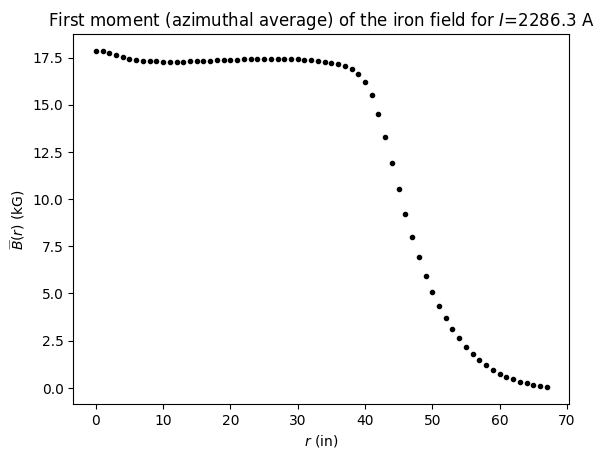

In [5]:
import matplotlib.pyplot as plt
print(f'Metadata for the field: {iron_field.metadata}')
plt.plot(iron_field.r_values, iron_field.first_moment()/1000, 'k.')
plt.xlabel(r'$r$ (in)')
plt.ylabel(r'$\widebar{B}(r)$ (kG)')
plt.title(f'First moment (azimuthal average) of the iron field for $I$={main_current:.1f} A')
plt.show()

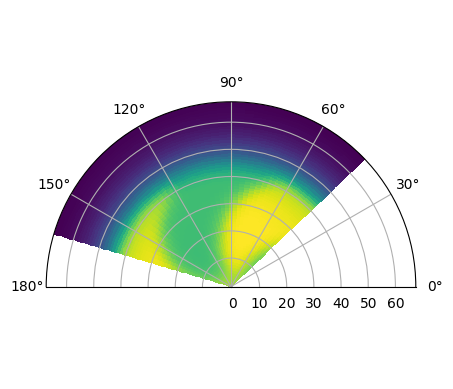

In [19]:
r = iron_field.r_values
th = np.deg2rad(iron_field.theta_values)

rr, tt = np.meshgrid(r, th)
plt.subplot(projection='polar')
plt.pcolormesh(tt, rr, iron_field.values, shading='auto')
plt.gca().set_thetamax(180)
plt.show()

Note that the magnetic field values are indexed by $\theta$ and then $r$,

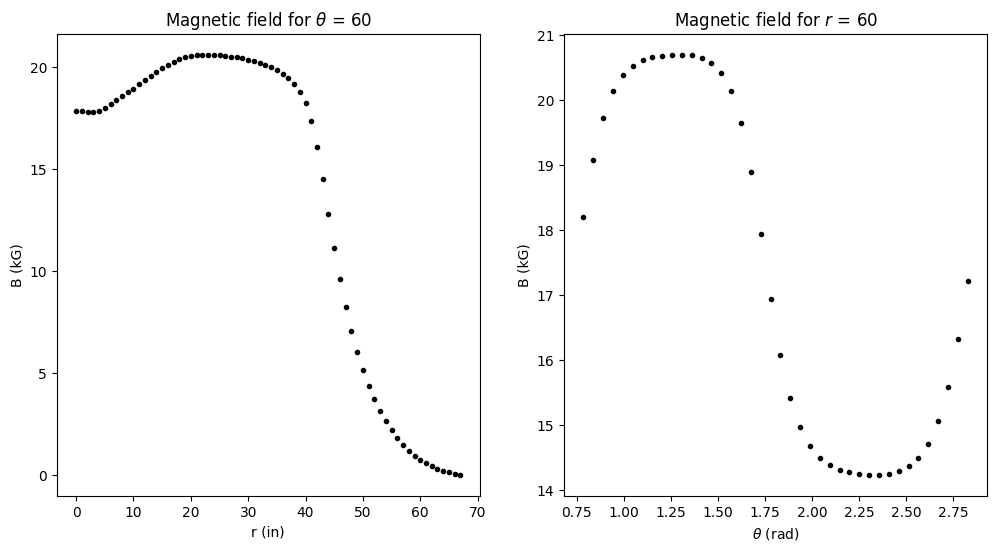

In [35]:
_, axs = plt.subplots(ncols=2, figsize=(12,6))
i = int((60 - iron_field.metadata.theta_min)/iron_field.metadata.delta_theta)
ax = axs[0]
ax.plot(r, iron_field.values[i,:]/1000, '.k')
ax.set_title(r'Magnetic field for $\theta$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel('r (in)')

ax = axs[1]
ax.plot(th, iron_field.values[:,20]/1000, '.k')
ax.set_title(r'Magnetic field for $r$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel(r'$\theta$ (rad)')
plt.show()